# Battle of the Neighborhoods
## Applied Data Science Capstone - Final Project

See Final Report for additional information regarding the problem statement.

### Problem:
An entrepreneur wants to open up a coffee shop in Toronto, and needs to determine what the best location would be.

### Approach:
In order to determine the best location to open up a donut shop in Toronto, we need to determine:
- Number/location of existing coffee shops
- Number/location of existing office buildings
- Locations where there are existing office buildings without a coffee shop nearby (target area)

## -------------------- Step 1: Get postal code data and geographical coordinates --------------------

In [1]:
# import libraries
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests

In [2]:
# get data from Wikipedia link
wiki_link='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
raw_wiki= requests.get(wiki_link).text

In [3]:
# use BeautifulSoup
soup_wiki = BeautifulSoup(raw_wiki,'lxml')

In [4]:
# store data from the HTML page into a list
wiki_data = []
wiki_col = []
wiki_table = soup_wiki.find(class_='wikitable')

for index, tr in enumerate(wiki_table.find_all('tr')):
    section = []
    for td in tr.find_all(['th','td']):
        section.append(td.text.rstrip())
        
    # first row is headers
    if (index == 0):
        col = section
    else:
        wiki_data.append(section)

# convert list to dataframe
wiki_df = pd.DataFrame(data = wiki_data,columns = col)
wiki_df.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [5]:
# remove rows with 'Not assigned' in the Borough column
wiki_df = wiki_df[wiki_df['Borough'] != 'Not assigned']
wiki_df.head()

,Postal Code,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [6]:
# remove duplicates
wiki_df = wiki_df.drop_duplicates()

# combine Neighbourhoods with same Postal Code into one row, with the Neighbourhoods separated with a comma
wiki_df["Neighbourhood"] = wiki_df.groupby("Postal Code")["Neighbourhood"].transform(lambda neigh: ', '.join(neigh))

# reset the index to start at zero
wiki_df.reset_index(inplace=True,drop=True)

wiki_df.head()

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [7]:
# for cells with a 'Not assigned' Neighbourhood, make the Neighbourhood the same as the Borough
wiki_df['Neighbourhood'].replace("Not assigned", wiki_df["Borough"],inplace=True)
wiki_df.head()

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [8]:
wiki_df.shape

(103, 3)

In [9]:
# use provided csv link to obtain coordinates
csv_link = 'http://cocl.us/Geospatial_data'
df_coordinates = pd.read_csv(csv_link)
df_coordinates.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [10]:
# combine dataframes
df_toronto = pd.merge(wiki_df, df_coordinates, how='left', left_on = 'Postal Code', right_on = 'Postal Code')
df_toronto.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [11]:
# import Nominatim (converts address to latitude and longitude)
from geopy.geocoders import Nominatim

# get the corrdinates of Toronto, Canada
address = "Toronto, ON"
geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of',address,'are (',latitude,', ',longitude,').')

The geograpical coordinates of Toronto, ON are ( 43.6534817 ,  -79.3839347 ).


In [12]:
# install and import folium (for map)
!pip install folium
import folium

     |████████████████████████████████| 93 kB 3.0 MB/s  eta 0:00:01


In [13]:
# create map of Toronto
toronto_map = folium.Map(location=[latitude, longitude], zoom_start=10)
toronto_map

### Because maps have trouble showing up on Github, here is a partial screenshot of it:
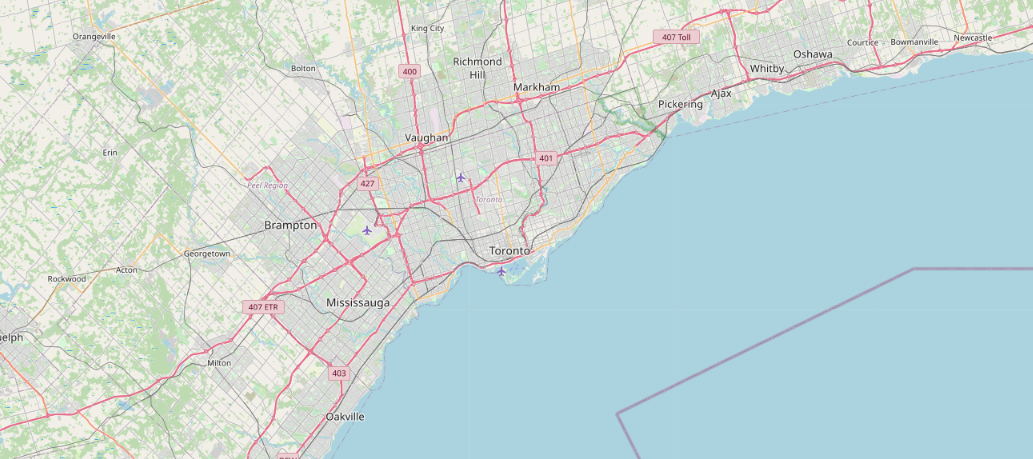

In [14]:
# mark locations on the map for each latitude and longitude listed in the table

# for each row in the dataframe...
for lat, long, borough, neighbourhood in zip(
        df_toronto['Latitude'], 
        df_toronto['Longitude'], 
        df_toronto['Borough'], 
        df_toronto['Neighbourhood']):
    # format label as "neighbourhood, borough" and make it a pop up
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    # make a green circle for each point
    folium.CircleMarker(
        [lat, long],
        radius=4,
        popup=label,
        color='green',
        fill=True,
        fill_color='#1FDD07',
        fill_opacity=0.8,
        parse_html=False).add_to(toronto_map)  

toronto_map

### Because maps have trouble showing up in Github, here is a partial screenshot of it:
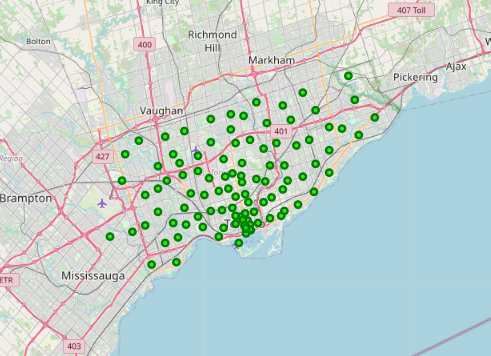

## -------------------- Step 2: Obtain number/location of existing coffee shops --------------------

### Note: In order to avoid posting Foursquare credentials publically, they will be replaced with 'REDACTED' when posted to the Github repository

In [95]:
# set client ID, client secret, and version (these will be replaced with 'REDACTED' on the Github repository)
CLIENT_ID = 'REDACTED'
CLIENT_SECRET = 'REDACTED'
ACCESS_TOKEN = 'REDACTED'
VERSION = '20180605'

In [16]:
# import json_normalize
from pandas import json_normalize

In [21]:
# define a function to find the number of nearby coffee shops (max: 100)
def getCoffeeShops(names, latitudes, longitudes, radius=500):
    venues_list=[]
    limit=100
    radius=500
    search_query='coffee'
    
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            lat,
            lng,
            ACCESS_TOKEN,
            VERSION,
            search_query,
            radius,
            limit)

        # put the results in a json file
        results = requests.get(url).json()["response"]['venues']
        
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],  
            v['categories']) for v in results])

    coffee_shops = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    coffee_shops.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(coffee_shops)

In [22]:
# create a dataframe for the coffee shops (max: 100) for each neighborhood in the list
toronto_coffee = getCoffeeShops(names=df_toronto['Neighbourhood'],
                                   latitudes=df_toronto['Latitude'],
                                   longitudes=df_toronto['Longitude']
                                  )
toronto_coffee.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Arena Coffee Bar,43.650280,-79.358860,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C..."
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C..."
2,"Regent Park, Harbourfront",43.65426,-79.360636,Coffee Time,43.654541,-79.364147,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C..."
3,"Regent Park, Harbourfront",43.65426,-79.360636,Coffee Enterprise,43.657290,-79.357592,"[{'id': '4bf58dd8d48988d125941735', 'name': 'T..."
4,"Regent Park, Harbourfront",43.65426,-79.360636,Coffee Mobile - Brand Partners,43.657487,-79.356930,"[{'id': '4bf58dd8d48988d125941735', 'name': 'T..."


In [24]:
# define a function to get the category of these venues
def get_category_type(row):
    try:
        categories_list = row['Venue Category']
    except:
        categories_list = row['venue.Venue Category']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [26]:
# filter the category for each row
toronto_coffee_filt = toronto_coffee
toronto_coffee_filt['Venue Category'] = toronto_coffee_filt.apply(get_category_type, axis=1)

toronto_coffee_filt.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Arena Coffee Bar,43.650280,-79.358860,Coffee Shop
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Coffee Time,43.654541,-79.364147,Coffee Shop
3,"Regent Park, Harbourfront",43.65426,-79.360636,Coffee Enterprise,43.657290,-79.357592,Tech Startup
4,"Regent Park, Harbourfront",43.65426,-79.360636,Coffee Mobile - Brand Partners,43.657487,-79.356930,Tech Startup


In [28]:
# remove rows where the venue is not actually 'Coffee Shop' (for instance, you can see above that some tech startups have 'Coffee' in their name)
toronto_coffee_filt = toronto_coffee_filt[toronto_coffee_filt['Venue Category'] == 'Coffee Shop']
toronto_coffee_filt.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Arena Coffee Bar,43.650280,-79.358860,Coffee Shop
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Coffee Time,43.654541,-79.364147,Coffee Shop
9,"Regent Park, Harbourfront",43.65426,-79.360636,Balzac's Coffee,43.649797,-79.359142,Coffee Shop
10,"Regent Park, Harbourfront",43.65426,-79.360636,Rooster Coffee,43.651900,-79.365609,Coffee Shop


In [34]:
# check how many coffee shops were returned for each neighborhood
toronto_coffee_numbers = toronto_coffee_filt
# remove unnecessary rows (all we need for this one is the neighborhoods, and the number of coffee shops)
del toronto_coffee_numbers['Neighborhood Latitude']
del toronto_coffee_numbers['Neighborhood Longitude']
del toronto_coffee_numbers['Venue Latitude']
del toronto_coffee_numbers['Venue Longitude']
del toronto_coffee_numbers['Venue Category']
toronto_coffee_count = toronto_coffee_numbers.rename(columns={'Venue': 'Coffee Shops'})
toronto_coffee_count.groupby('Neighborhood').count()

,Coffee Shops
Neighborhood,
"Alderwood, Long Branch",1
Berczy Park,8
"Brockton, Parkdale Village, Exhibition Place",5
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",1
Cedarbrae,1
Central Bay Street,22
Church and Wellesley,8
"Commerce Court, Victoria Hotel",26
Davisville,2


### As seen in the above table, these areas have numbers of coffee shops ranging from 1 - 27

## -------------------- Step 3: Obtain number/location of existing office buildings --------------------

In [37]:
# define a function to find the number of nearby office buildings (max: 100)
def getOfficeBuildings(names, latitudes, longitudes, radius=500):
    venues_list=[]
    limit=100
    radius=500
    search_query='office'
    
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            lat,
            lng,
            ACCESS_TOKEN,
            VERSION,
            search_query,
            radius,
            limit)

        # put the results in a json file
        results = requests.get(url).json()["response"]['venues']
        
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],  
            v['categories']) for v in results])

    office_buildings = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    office_buildings.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(office_buildings)

In [64]:
# create a dataframe for the office buildings (max: 100) for each neighborhood in the list
toronto_office = getOfficeBuildings(names=df_toronto['Neighbourhood'],
                                   latitudes=df_toronto['Latitude'],
                                   longitudes=df_toronto['Longitude']
                                  )
toronto_office.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Victoria Village,43.725882,-79.315572,Oasis Dental Office,43.725950,-79.312322,[]
1,Victoria Village,43.725882,-79.315572,Beck Taxi Head Offices,43.725883,-79.318173,"[{'id': '54541b70498ea6ccd0204bff', 'name': 'T..."
2,"Regent Park, Harbourfront",43.654260,-79.360636,iRunRealEstate Corktown-Distillery Office,43.652783,-79.363775,"[{'id': '5032885091d4c4b30a586d66', 'name': 'R..."
3,"Regent Park, Harbourfront",43.654260,-79.360636,Brian Chang Campaign Office (ChangQ),43.655601,-79.364993,"[{'id': '5032764e91d4c4b30a586d5a', 'name': 'C..."
4,"Regent Park, Harbourfront",43.654260,-79.360636,Toronto Centre Riding Office,43.653162,-79.363482,"[{'id': '4bf58dd8d48988d126941735', 'name': 'G..."


In [65]:
# filter the category for each row
toronto_office_filt = toronto_office
toronto_office_filt['Venue Category'] = toronto_office_filt.apply(get_category_type, axis=1)

toronto_office_filt.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Victoria Village,43.725882,-79.315572,Oasis Dental Office,43.725950,-79.312322,None
1,Victoria Village,43.725882,-79.315572,Beck Taxi Head Offices,43.725883,-79.318173,Transportation Service
2,"Regent Park, Harbourfront",43.654260,-79.360636,iRunRealEstate Corktown-Distillery Office,43.652783,-79.363775,Real Estate Office
3,"Regent Park, Harbourfront",43.654260,-79.360636,Brian Chang Campaign Office (ChangQ),43.655601,-79.364993,Campaign Office
4,"Regent Park, Harbourfront",43.654260,-79.360636,Toronto Centre Riding Office,43.653162,-79.363482,Government Building


In [66]:
# remove rows where the venue is not actually 'Office'
toronto_office_filt = toronto_office_filt[toronto_office_filt['Venue Category'] == 'Office']
toronto_office_filt.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
5,"Regent Park, Harbourfront",43.65426,-79.360636,CourtCanada office,43.653356,-79.363572,Office
6,"Regent Park, Harbourfront",43.65426,-79.360636,Meetings & Incentive Travel Magazine Office,43.654440,-79.364690,Office
7,"Regent Park, Harbourfront",43.65426,-79.360636,White Lioness Media Office,43.657505,-79.356887,Office
8,"Regent Park, Harbourfront",43.65426,-79.360636,Nancy's Office,43.654000,-79.366990,Office
9,"Regent Park, Harbourfront",43.65426,-79.360636,Infrastructure Ontario PAAV Office,43.650131,-79.364561,Office


In [67]:
# check how many office buildings were returned for each neighborhood
toronto_office_numbers = toronto_office_filt
# remove unnecessary rows (all we need for this one is the neighborhoods, and the number of office buildings)
del toronto_office_numbers['Neighborhood Latitude']
del toronto_office_numbers['Neighborhood Longitude']
del toronto_office_numbers['Venue Latitude']
del toronto_office_numbers['Venue Longitude']
del toronto_office_numbers['Venue Category']
toronto_office_count = toronto_office_numbers.rename(columns={'Venue': 'Office Buildings'})
toronto_office_count.groupby('Neighborhood').count()

,Office Buildings
Neighborhood,
"Bedford Park, Lawrence Manor East",1
Berczy Park,22
"Brockton, Parkdale Village, Exhibition Place",4
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",1
Canada Post Gateway Processing Centre,2
Cedarbrae,1
Central Bay Street,15
Christie,3
Church and Wellesley,21


### As seen in the above table, these areas have numbers of offices ranging from 1 - 23

## -------------------- Step 4: Compare locations of coffee shops and office buildings --------------------

In [50]:
# create dataframe that includes just the neighborhood and number of coffee shops
toronto_count_coffee = toronto_coffee_filt
# remove unnecessary rows (all we need for this one is the neighborhoods, and the number of office buildings)
del toronto_count_coffee['Venue Latitude']
del toronto_count_coffee['Venue Longitude']
del toronto_count_coffee['Venue Category']
toronto_count_coffee = toronto_count_coffee.rename(columns={'Venue': 'Coffee Shops'})

toronto_count_coffee = toronto_count_coffee.groupby('Neighborhood').count()
toronto_count_coffee.head()

,Coffee Shops
Neighborhood,
"Alderwood, Long Branch",1
Berczy Park,8
"Brockton, Parkdale Village, Exhibition Place",5
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",1
Cedarbrae,1


In [48]:
# create dataframe that includes just the neighborhood and number of office buildings
toronto_count_offices = toronto_office_filt
# remove unnecessary rows (all we need for this one is the neighborhoods, and the number of office buildings)
del toronto_count_offices['Venue Latitude']
del toronto_count_offices['Venue Longitude']
del toronto_count_offices['Venue Category']
toronto_count_offices = toronto_count_offices.rename(columns={'Venue': 'Office Buildings'})

toronto_count_offices = toronto_count_offices.groupby('Neighborhood').count()
toronto_count_offices.head()

,Office Buildings
Neighborhood,
"Bedford Park, Lawrence Manor East",1
Berczy Park,22
"Brockton, Parkdale Village, Exhibition Place",4
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",1
Canada Post Gateway Processing Centre,2


In [55]:
# merge the two dataframes
toronto_merged = pd.merge(toronto_count_coffee,toronto_count_offices,on='Neighborhood',how='outer')
toronto_merged.head()

,Coffee Shops,Office Buildings
Neighborhood,,
"Alderwood, Long Branch",1.0,NaN
Berczy Park,8.0,22.0
"Brockton, Parkdale Village, Exhibition Place",5.0,4.0
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",1.0,1.0
Cedarbrae,1.0,1.0


In [59]:
# replace any instances of 'NaN' with 0
toronto_merged_cleaned = toronto_merged
toronto_merged_cleaned['Coffee Shops'] = toronto_merged['Coffee Shops'].fillna(0)
toronto_merged_cleaned['Office Buildings'] = toronto_merged['Office Buildings'].fillna(0)
toronto_merged_cleaned

,Coffee Shops,Office Buildings
Neighborhood,,
"Alderwood, Long Branch",1.0,0.0
Berczy Park,8.0,22.0
"Brockton, Parkdale Village, Exhibition Place",5.0,4.0
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",1.0,1.0
Cedarbrae,1.0,1.0
Central Bay Street,22.0,15.0
Church and Wellesley,8.0,21.0
"Commerce Court, Victoria Hotel",26.0,20.0
Davisville,2.0,6.0


### As seen in the above table, there are some neighborhoods that have only coffee shops or office buildings

In [76]:
# add back in the coordinates, postal code, and borough
df_toronto_renamed = df_toronto.rename(columns={'Neighbourhood': 'Neighborhood'})
toronto_final = pd.merge(toronto_merged_cleaned,df_toronto_renamed,on='Neighborhood')
toronto_final = toronto_final.drop_duplicates(keep='first')
toronto_final.reset_index(inplace=True,drop=True)
toronto_final

,Neighborhood,Coffee Shops,Office Buildings,Postal Code,Borough,Latitude,Longitude
0,"Alderwood, Long Branch",1.0,0.0,M8W,Etobicoke,43.602414,-79.543484
1,Berczy Park,8.0,22.0,M5E,Downtown Toronto,43.644771,-79.373306
2,"Brockton, Parkdale Village, Exhibition Place",5.0,4.0,M6K,West Toronto,43.636847,-79.428191
3,"CN Tower, King and Spadina, Railway Lands, Har...",1.0,1.0,M5V,Downtown Toronto,43.628947,-79.394420
4,Cedarbrae,1.0,1.0,M1H,Scarborough,43.773136,-79.239476
5,Central Bay Street,22.0,15.0,M5G,Downtown Toronto,43.657952,-79.387383
6,Church and Wellesley,8.0,21.0,M4Y,Downtown Toronto,43.665860,-79.383160
7,"Commerce Court, Victoria Hotel",26.0,20.0,M5L,Downtown Toronto,43.648198,-79.379817
8,Davisville,2.0,6.0,M4S,Central Toronto,43.704324,-79.388790
9,"Del Ray, Mount Dennis, Keelsdale and Silverthorn",1.0,0.0,M6M,York,43.691116,-79.476013


In [77]:
# import k-means
from sklearn.cluster import KMeans

In [80]:
# run k means to cluster the neighborhood into 5 clusters
kclusters = 5
toronto_clusters = toronto_final.drop('Neighborhood',1)
toronto_clusters = toronto_clusters.drop('Postal Code',1)
toronto_clusters = toronto_clusters.drop('Borough',1)
toronto_clusters = toronto_clusters.drop('Latitude',1)
toronto_clusters = toronto_clusters.drop('Longitude',1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_clusters)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 0, 4, 1, 1, 2, 0, 2, 3, 1], dtype=int32)

In [86]:
# add the cluster numbers to the dataframe
toronto_clustered = toronto_final
toronto_clustered.insert(0,'Cluster Labels',kmeans.labels_)
toronto_clustered.head()

,Cluster Labels,Neighborhood,Coffee Shops,Office Buildings,Postal Code,Borough,Latitude,Longitude
0,1,"Alderwood, Long Branch",1.0,0.0,M8W,Etobicoke,43.602414,-79.543484
1,0,Berczy Park,8.0,22.0,M5E,Downtown Toronto,43.644771,-79.373306
2,4,"Brockton, Parkdale Village, Exhibition Place",5.0,4.0,M6K,West Toronto,43.636847,-79.428191
3,1,"CN Tower, King and Spadina, Railway Lands, Har...",1.0,1.0,M5V,Downtown Toronto,43.628947,-79.394420
4,1,Cedarbrae,1.0,1.0,M1H,Scarborough,43.773136,-79.239476


In [87]:
# import colors (for the map)
import matplotlib.cm as cm
import matplotlib.colors as colors

In [88]:
# create a map (same process as before), showing the resulting clusters
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(
        toronto_clustered['Latitude'], 
        toronto_clustered['Longitude'], 
        toronto_clustered['Neighborhood'], 
        toronto_clustered['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters)
       
map_clusters

### Because Github tends to have trouble displaying the map, here's a partial screenshot:
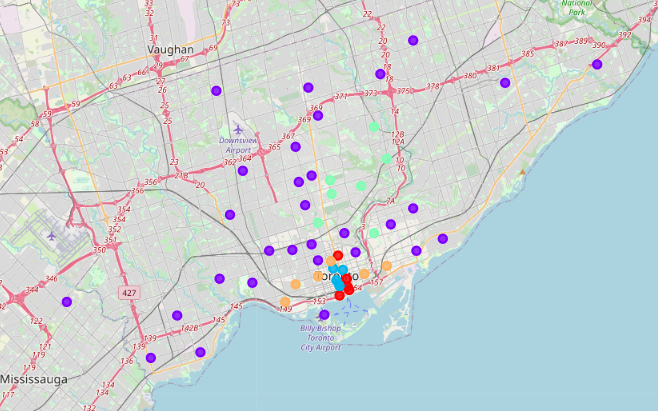

In [90]:
# Examine each cluster
# Cluster 1
toronto_clustered.loc[toronto_clustered['Cluster Labels'] == 0]

,Cluster Labels,Neighborhood,Coffee Shops,Office Buildings,Postal Code,Borough,Latitude,Longitude
1,0,Berczy Park,8.0,22.0,M5E,Downtown Toronto,43.644771,-79.373306
6,0,Church and Wellesley,8.0,21.0,M4Y,Downtown Toronto,43.665860,-79.383160
15,0,"Harbourfront East, Union Station, Toronto Islands",11.0,16.0,M5J,Downtown Toronto,43.640816,-79.381752
27,0,St. James Town,17.0,23.0,M5C,Downtown Toronto,43.651494,-79.375418
30,0,Stn A PO Boxes,17.0,20.0,M5W,Downtown Toronto,43.646435,-79.374846


In [91]:
# Examine each cluster
# Cluster 2
toronto_clustered.loc[toronto_clustered['Cluster Labels'] == 1]

,Cluster Labels,Neighborhood,Coffee Shops,Office Buildings,Postal Code,Borough,Latitude,Longitude
0,1,"Alderwood, Long Branch",1.0,0.0,M8W,Etobicoke,43.602414,-79.543484
3,1,"CN Tower, King and Spadina, Railway Lands, Har...",1.0,1.0,M5V,Downtown Toronto,43.628947,-79.394420
4,1,Cedarbrae,1.0,1.0,M1H,Scarborough,43.773136,-79.239476
9,1,"Del Ray, Mount Dennis, Keelsdale and Silverthorn",1.0,0.0,M6M,York,43.691116,-79.476013
10,1,"Dufferin, Dovercourt Village",2.0,3.0,M6H,West Toronto,43.669005,-79.442259
11,1,"East Toronto, Broadview North (Old East York)",1.0,0.0,M4J,East York,43.685347,-79.338106
12,1,"Fairview, Henry Farm, Oriole",3.0,2.0,M2J,North York,43.778517,-79.346556
16,1,"India Bazaar, The Beaches West",1.0,1.0,M4L,East Toronto,43.668999,-79.315572
19,1,"Mimico NW, The Queensway West, South of Bloor,...",1.0,0.0,M8Z,Etobicoke,43.628841,-79.520999
20,1,"New Toronto, Mimico South, Humber Bay Shores",2.0,0.0,M8V,Etobicoke,43.605647,-79.501321


In [92]:
# Examine each cluster
# Cluster 3
toronto_clustered.loc[toronto_clustered['Cluster Labels'] == 2]

,Cluster Labels,Neighborhood,Coffee Shops,Office Buildings,Postal Code,Borough,Latitude,Longitude
5,2,Central Bay Street,22.0,15.0,M5G,Downtown Toronto,43.657952,-79.387383
7,2,"Commerce Court, Victoria Hotel",26.0,20.0,M5L,Downtown Toronto,43.648198,-79.379817
13,2,"First Canadian Place, Underground city",27.0,23.0,M5X,Downtown Toronto,43.648429,-79.382280
14,2,"Garden District, Ryerson",25.0,16.0,M5B,Downtown Toronto,43.657162,-79.378937
24,2,"Richmond, Adelaide, King",27.0,20.0,M5H,Downtown Toronto,43.650571,-79.384568
36,2,"Toronto Dominion Centre, Design Exchange",23.0,23.0,M5K,Downtown Toronto,43.647177,-79.381576


In [93]:
# Examine each cluster
# Cluster 4
toronto_clustered.loc[toronto_clustered['Cluster Labels'] == 3]

,Cluster Labels,Neighborhood,Coffee Shops,Office Buildings,Postal Code,Borough,Latitude,Longitude
8,3,Davisville,2.0,6.0,M4S,Central Toronto,43.704324,-79.388790
32,3,"Summerhill West, Rathnelly, South Hill, Forest...",1.0,5.0,M4V,Central Toronto,43.686412,-79.400049
35,3,"The Danforth West, Riverdale",3.0,5.0,M4K,East Toronto,43.679557,-79.352188
42,3,Davisville North,0.0,6.0,M4P,Central Toronto,43.712751,-79.390197
43,3,Don Mills,0.0,8.0,M3B,North York,43.745906,-79.352188
44,3,Don Mills,0.0,8.0,M3C,North York,43.725900,-79.340923
47,3,Leaside,0.0,4.0,M4G,East York,43.709060,-79.363452


In [94]:
# Examine each cluster
# Cluster 5
toronto_clustered.loc[toronto_clustered['Cluster Labels'] == 4]

,Cluster Labels,Neighborhood,Coffee Shops,Office Buildings,Postal Code,Borough,Latitude,Longitude
2,4,"Brockton, Parkdale Village, Exhibition Place",5.0,4.0,M6K,West Toronto,43.636847,-79.428191
17,4,"Kensington Market, Chinatown, Grange Park",7.0,5.0,M5T,Downtown Toronto,43.653206,-79.400049
18,4,"Little Portugal, Trinity",6.0,1.0,M6J,West Toronto,43.647927,-79.419750
22,4,"Queen's Park, Ontario Provincial Government",10.0,5.0,M7A,Downtown Toronto,43.662301,-79.389494
23,4,"Regent Park, Harbourfront",6.0,6.0,M5A,Downtown Toronto,43.654260,-79.360636
31,4,Studio District,4.0,3.0,M4M,East Toronto,43.659526,-79.340923


## -------------------- Final Step: Make Observations and Conclusions --------------------

### Cluster 1 Observations:
- High amount of office buildings, moderate amount of coffee shops
- Roughly 2 office buildings per coffee shop

### Cluster 2 Observations:
- Low amount of both coffee shops and office buildings
- Roughly equal amount of office buildings and coffee shops

### Cluster 3 Observations:
- High amount of both coffee shops and office buildings
- Roughly equal amount of office buildings and coffee shops

### Cluster 4 Observations:
- Moderate amount of office buildings, low amount of coffee shops
- Roughly 5 office buildings per coffee shop

### Cluster 5 Observations:
- Moderate amount of both coffee shops and office buildings
- Roughly 1-2 coffee shops per office building

### Conclusions:
Of the five clusters generated in this project, four of them have a ratio of coffee shops to office buildings of roughly 1:1 or 2:1. Only one cluster (Cluster 4) has a drastically different ratio of 1:5 (or only 1 coffee shop per 5 office bulidings). This means that of the five clusters, cluster 5 has the most clear need for new coffee shops. Therefore, the neighborhoods in this cluster would be a good place for an entrepreneur to open one up.